# Breast Cancer Classification

Breast cancer is cancer that develops from breast tissue. Signs of breast cancer may include a lump in the breast, a change in breast shape, dimpling of the skin, fluid coming from the nipple, a newly inverted nipple, or a red or scaly patch of skin. In those with distant spread of the disease, there may be bone pain, swollen lymph nodes, shortness of breath, or yellow skin.

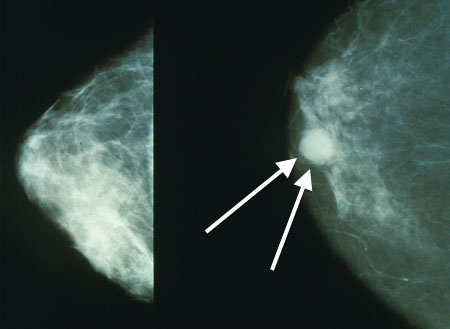

1. [Libraries and Utilities](#2)   
2. [Load and Check Data](#3)   
    - [Malignant to 1 and Bening to 0](#4)
3. [Exploratory Data Analysis](#5)
    - [Correlation Map](#6)
4. [Outlier Detection](#7)
5. [Drop Outliers](#8)
6. [Train Test Split](#9)
7. [Standardization](#10)
8. [Basic KNN Method](#11)
    - [Finding Best KNN Parameters](#12)
9. [Principal Component Analysis](#13)
10. [Neighborhood Component Analysis (NCA)](#14)
    - [Finding Wrong Decision](#15)

<a id = "2"></a>
# Libraries and Utilities

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breast-cancer-wisconsin-data/data.csv


<a id = "3"></a>
# Load and Check Data

In [2]:
data = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
data.drop(["Unnamed: 32","id"], axis = 1, inplace =True)
data = data.rename(columns = {"diagnosis":"target"})
data.head()

,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


B    357
M    212
Name: target, dtype: int64


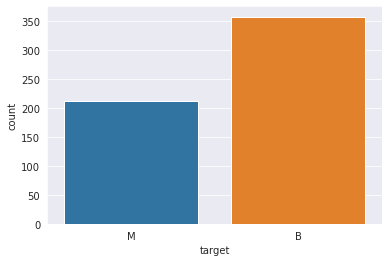

In [3]:
sns.countplot(data["target"])
print(data.target.value_counts())

<a id = "4"></a>
## Malignant to 1 and Bening to 0

In [4]:
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]
print("Data Shape:", data.shape)

Data Shape: (569, 31)


<a id = "5"></a>
# Exploratory Data Analysis

<a id = "6"></a>
## Correlation Map

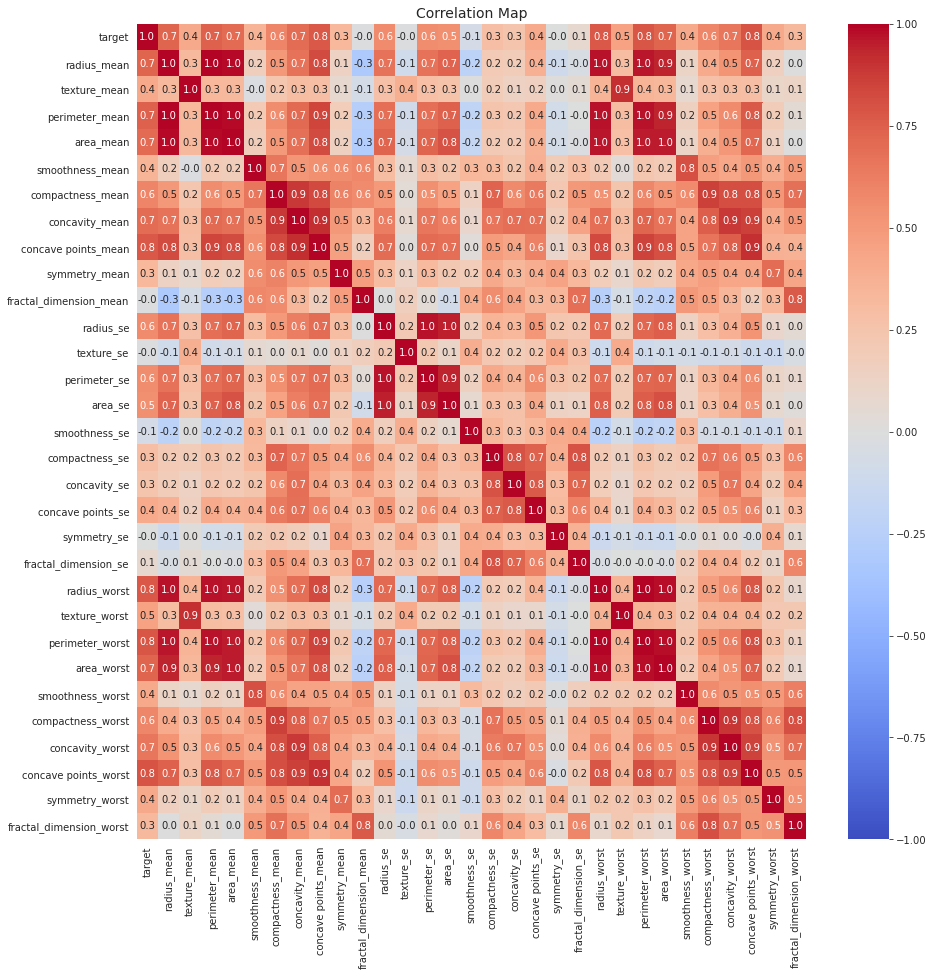

In [5]:
corr_matrix = data.corr()
f,ax=plt.subplots(figsize = (15,15))
sns.heatmap(corr_matrix,annot= True,fmt = ".1f",ax=ax,cmap='coolwarm',vmin=-1,vmax=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map', size = 14)
plt.show()

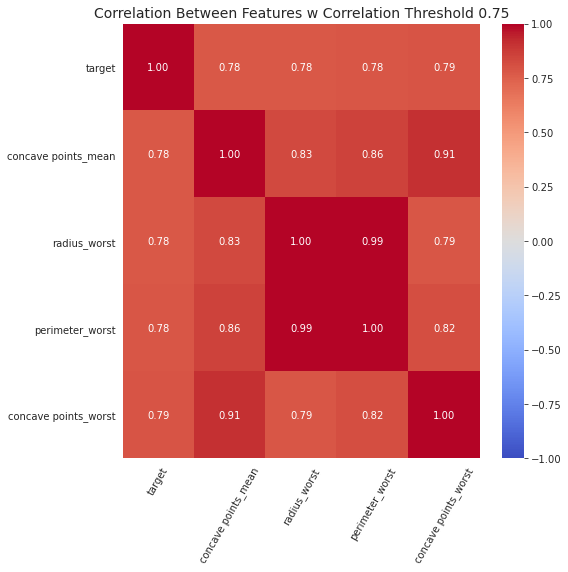

In [6]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
f,ax=plt.subplots(figsize = (8,8))
sns.heatmap(data[corr_features].corr(),annot= True,fmt = ".2f",ax=ax,cmap='coolwarm',vmin=-1,vmax=1)
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.title("Correlation Between Features w Correlation Threshold 0.75", size = 14)
plt.show()

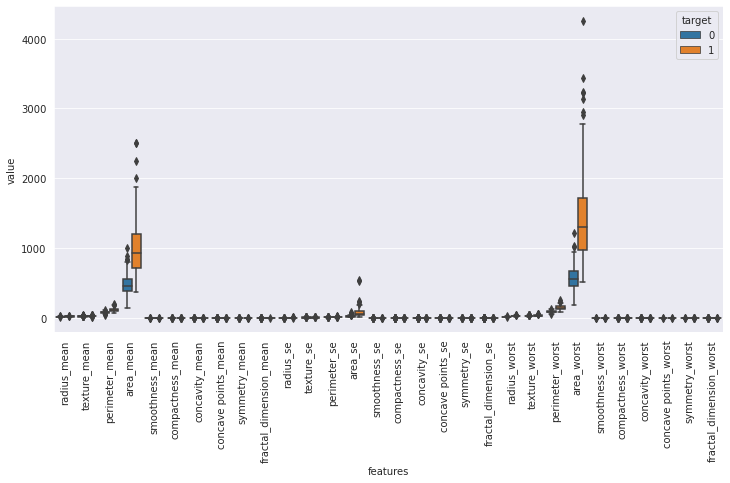

In [7]:
data_melted = pd.melt(data, id_vars = "target",
                     var_name = "features",
                     value_name = "value")
plt.figure(figsize = (12,6))
sns.boxplot(x = "features", y ="value", hue = "target", data = data_melted)
plt.xticks(rotation = 90);

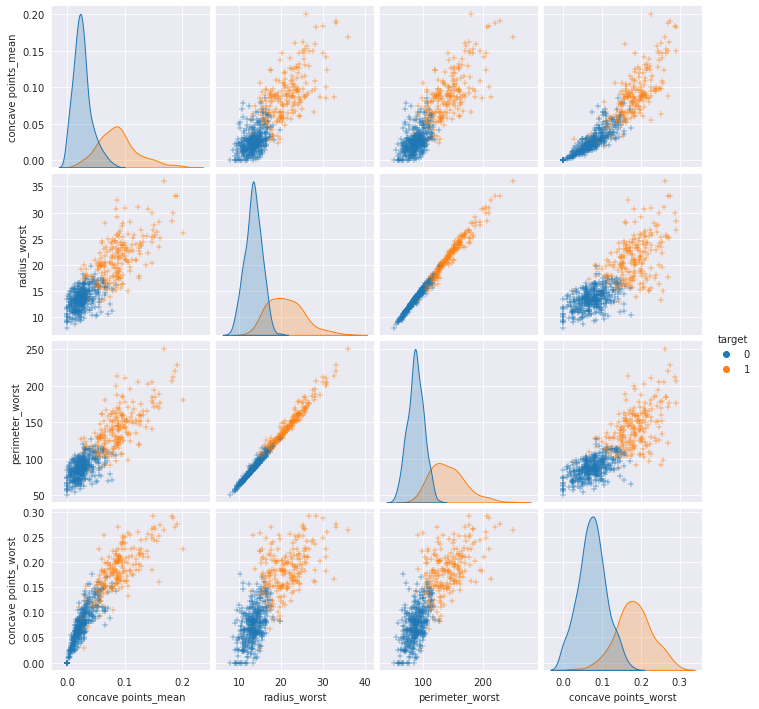

In [8]:
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "target")
plt.show()

<a id = "7"></a>
# Outlier Detection

In [9]:
y = data.target
x = data.drop(["target"], axis = 1)
columns = x.columns.tolist()
columns

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [10]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)
X_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score
outlier_score.head()

,score
0,-1.422440
1,-1.066782
2,-0.978948
3,-1.596933
4,-1.069936


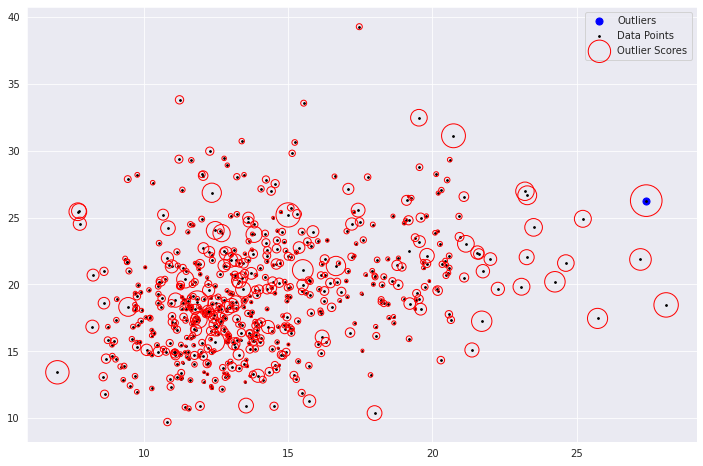

In [11]:
radius = (X_score.max() - X_score) / (X_score.max() - X_score.min())
outlier_score["radius"] = radius
threshold = -2.5
filter_ = outlier_score["score"] < threshold
outlier_index = outlier_score[filter_].index.tolist()
plt.figure(figsize = (12,8))
plt.scatter(x.iloc[outlier_index,0],x.iloc[outlier_index,1], color = "blue", s = 50, label = "Outliers" )
plt.scatter(x.iloc[:,0],x.iloc[:,1], color = "k", s = 3, label = "Data Points" )
plt.scatter(x.iloc[:,0],x.iloc[:,1], s = 1000*radius, edgecolor = "r", facecolors = "none", label ="Outlier Scores")
plt.legend()
plt.show()

<a id = "8"></a>
# Drop Outliers

In [12]:
x = x.drop(outlier_index)
y = y.drop(outlier_index).values
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<a id = "9"></a>
# Train Test Split

In [13]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = test_size, random_state = 42)

<a id = "10"></a>
# Standardization

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
x_train_df = pd.DataFrame(X_train, columns = columns)
x_train_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.126206,-0.106331,-0.139113,-0.243152,0.200584,0.082163,-0.426589,-0.287204,-0.345793,0.802295,...,-0.243869,0.026662,-0.235439,-0.316803,0.456859,0.060010,-0.359469,0.218125,-0.054096,0.396185
1,1.110155,0.350378,1.085508,0.972350,0.516224,0.541814,0.433900,1.051074,0.668203,-0.276397,...,1.026425,-0.008771,0.960829,0.869669,0.705777,0.841678,0.340937,1.293014,0.281891,0.093907
2,-1.565931,-0.763715,-1.524658,-1.225782,1.326652,-0.408721,-0.589335,-0.780730,-0.582878,1.903286,...,-1.410326,-0.941303,-1.316628,-1.082299,1.762589,-0.075060,-0.092330,-0.146403,0.068515,1.048258
3,0.567081,-0.251647,0.550500,0.456043,0.061958,0.213772,0.101004,0.286230,0.190385,-0.026932,...,0.779600,-0.031319,0.679317,0.656981,-0.027877,-0.160648,0.085079,0.112194,-0.144860,-0.103605
4,-0.487293,0.172769,-0.488764,-0.531209,-0.840888,-0.027839,-0.238905,-0.468792,-0.101412,-0.025539,...,-0.594955,-0.385649,-0.585008,-0.592932,-1.180763,-0.212804,-0.375364,-0.594274,-0.315243,-0.329168


In [15]:
x_train_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,...,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02
mean,1.789780e-17,-2.863648e-16,-7.243017e-17,-2.245615e-16,-2.125364e-17,-2.377052e-16,2.768566e-17,1.138188e-16,-1.639187e-15,6.843113e-16,...,1.216491e-16,-4.810034e-16,-4.438096e-16,-9.620069e-17,7.100394e-16,-1.185729e-16,7.187086e-17,-6.795572e-17,-6.739641e-17,3.383803e-17
std,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,...,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00
min,-1.712388e+00,-2.175361e+00,-1.632924e+00,-1.303791e+00,-2.404872e+00,-1.638974e+00,-1.126020e+00,-1.291511e+00,-2.340956e+00,-1.731378e+00,...,-1.554165e+00,-2.165353e+00,-1.558852e+00,-1.163524e+00,-2.217924e+00,-1.426295e+00,-1.351626e+00,-1.782104e+00,-2.098683e+00,-1.623010e+00
25%,-7.039450e-01,-7.291157e-01,-7.065592e-01,-6.765379e-01,-7.086599e-01,-7.677983e-01,-7.505222e-01,-7.462174e-01,-6.923019e-01,-7.154003e-01,...,-6.821946e-01,-7.528643e-01,-7.019438e-01,-6.578384e-01,-7.527979e-01,-6.715073e-01,-7.547935e-01,-7.847938e-01,-6.687460e-01,-6.938485e-01
50%,-2.446426e-01,-1.109439e-01,-2.549616e-01,-2.989145e-01,-9.870612e-02,-2.500035e-01,-3.559314e-01,-3.888829e-01,-3.575803e-02,-1.774476e-01,...,-2.715302e-01,-5.708877e-02,-2.809144e-01,-3.430225e-01,-4.097822e-02,-2.830139e-01,-2.487165e-01,-2.253839e-01,-1.273445e-01,-2.398587e-01
75%,4.919745e-01,5.648931e-01,5.336490e-01,3.852569e-01,6.086412e-01,5.418139e-01,4.663710e-01,6.740944e-01,5.587789e-01,4.845408e-01,...,4.880926e-01,6.757303e-01,5.339215e-01,2.884427e-01,6.097035e-01,5.982844e-01,5.947450e-01,7.322025e-01,4.793437e-01,4.494271e-01
max,4.033514e+00,4.645288e+00,4.063861e+00,5.327298e+00,4.767417e+00,4.097233e+00,4.417475e+00,4.049923e+00,4.490747e+00,4.845302e+00,...,3.590418e+00,3.877586e+00,3.782128e+00,4.325859e+00,3.771406e+00,4.615614e+00,3.461489e+00,2.511223e+00,5.979346e+00,5.130159e+00


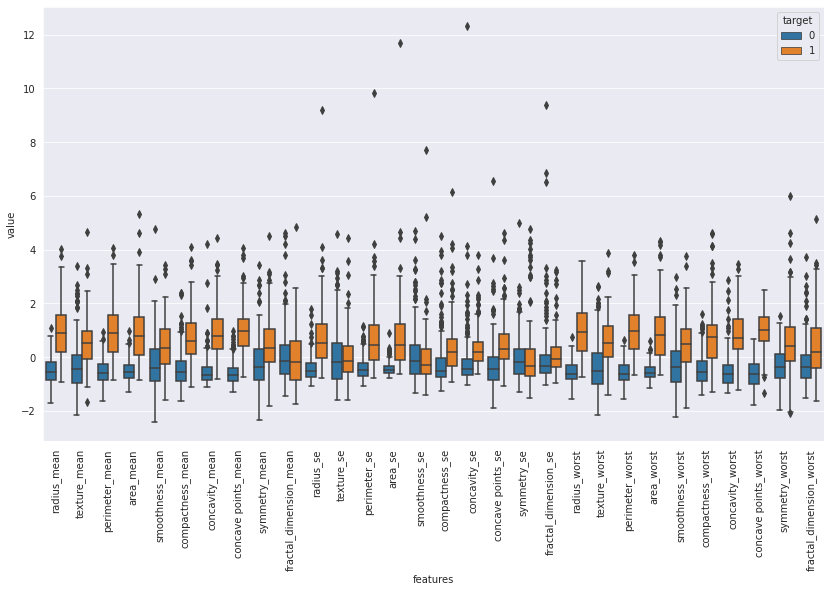

In [16]:
x_train_df["target"] = Y_train
data_melted = pd.melt(x_train_df, id_vars = "target",
                     var_name = "features",
                     value_name = "value")

plt.figure(figsize = (14,8))
sns.boxplot(x = "features", y ="value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

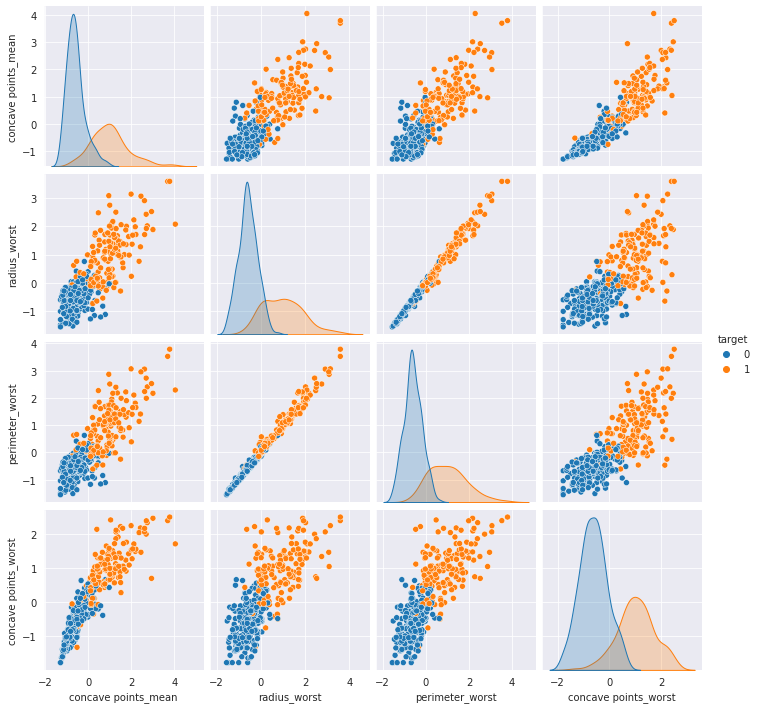

In [17]:
sns.pairplot(x_train_df[corr_features], diag_kind = "kde", hue = "target")
plt.show()

<a id = "11"></a>
# Basic KNN Method

In [18]:
knn = KNeighborsClassifier(n_neighbors= 2)
knn.fit(X_train,Y_train)
y_pred =  knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print("Score:", score)
print("CM:", cm)
print("Basic KNN Accuracy:", acc)

Score: 0.9532163742690059
CM: [[108   1]
 [  7  55]]
Basic KNN Accuracy: 0.9532163742690059


<a id = "12"></a>
## Finding Best KNN Parameters

In [19]:
def KNN_Best_Params(x_train, x_test, y_train,y_test):
    
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train)
    
    print("Best Training Score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
    print()
    
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train,y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    print("Test Score: {}, Train Score: {}".format(acc_test,acc_train))
    
    print()
    
    print("CM Test:" ,cm_test)
    print("CM Train:", cm_train)
    
    return grid

In [20]:
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)


Best Training Score: 0.9670512820512821 with parameters: {'n_neighbors': 4, 'weights': 'uniform'}

Test Score: 0.9590643274853801, Train Score: 0.9773299748110831

CM Test: [[107   2]
 [  5  57]]
CM Train: [[248   0]
 [  9 140]]


<a id = "13"></a>
# Principal Component Analysis

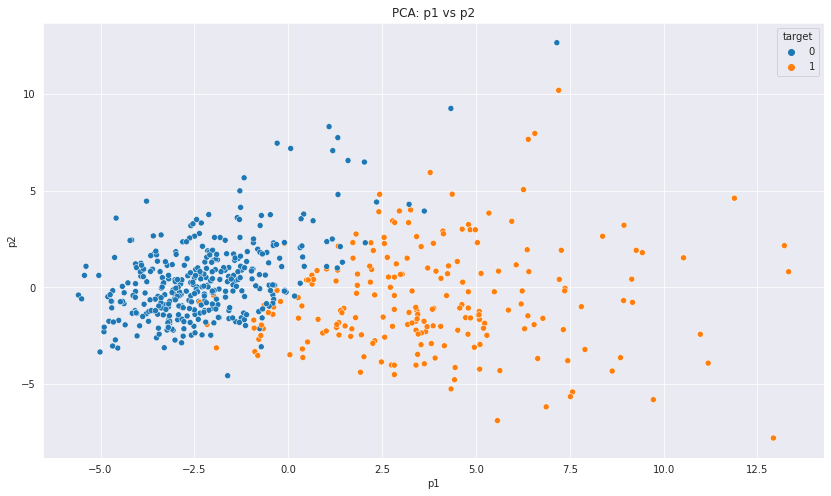

In [21]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1","p2"])
pca_data["target"] = y

plt.figure(figsize = (14,8))
sns.scatterplot(x = "p1", y = "p2", hue = "target", data = pca_data)
plt.title("PCA: p1 vs p2")
plt.show()

In [22]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y,test_size = test_size, random_state = 42)
grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)


Best Training Score: 0.9419230769230769 with parameters: {'n_neighbors': 9, 'weights': 'uniform'}

Test Score: 0.9239766081871345, Train Score: 0.947103274559194

CM Test: [[103   6]
 [  7  55]]
CM Train: [[241   7]
 [ 14 135]]


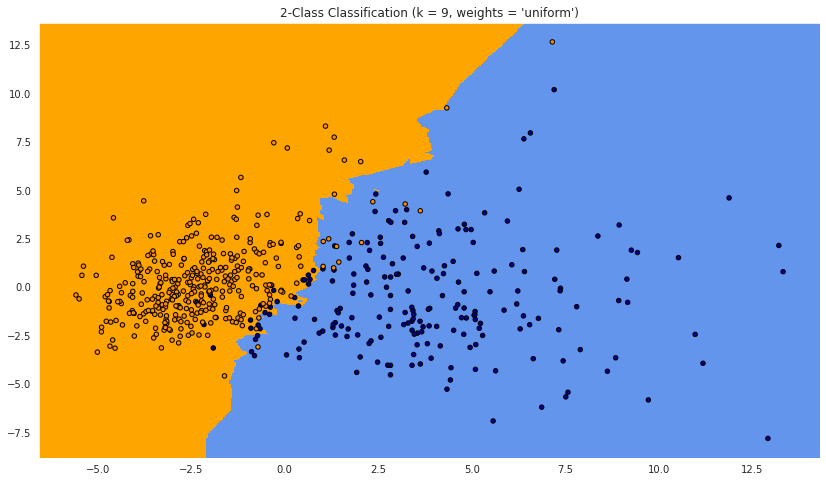

In [23]:
cmap_light = ListedColormap(['orange', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', "darkblue"])

h = 0.05
X = X_reduced_pca
x_min, x_max = X[:,0].min() -1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() -1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min,y_max,h))

Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize = (14,8))
plt.pcolormesh(xx,yy,Z, cmap = cmap_light)

plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,
           edgecolor = 'k', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class Classification (k = %i, weights = '%s')"
         % (len(np.unique(y)), grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))
plt.show()

<a id = "14"></a>
# Neighborhood Component Analysis (NCA)

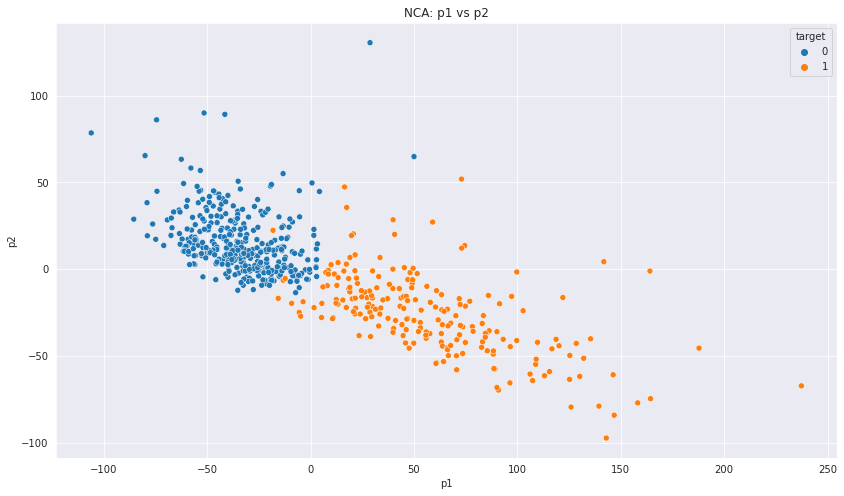

In [24]:
nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
nca.fit(x_scaled, y)
X_reduced_nca = nca.transform(x_scaled)
nca_data = pd.DataFrame(X_reduced_nca, columns = ["p1","p2"])
nca_data["target"] = y
plt.figure(figsize = (14,8))
sns.scatterplot(x = "p1", y= "p2", hue = "target", data = nca_data )
plt.title("NCA: p1 vs p2")
plt.show()

In [25]:
X_train_nca, X_test_nca, Y_train_nca, Y_test_nca = train_test_split(X_reduced_nca, y,test_size = test_size, random_state = 42)
grid_nca = KNN_Best_Params(X_train_nca, X_test_nca, Y_train_nca, Y_test_nca)


Best Training Score: 0.9873076923076922 with parameters: {'n_neighbors': 1, 'weights': 'uniform'}

Test Score: 0.9941520467836257, Train Score: 1.0

CM Test: [[108   1]
 [  0  62]]
CM Train: [[248   0]
 [  0 149]]


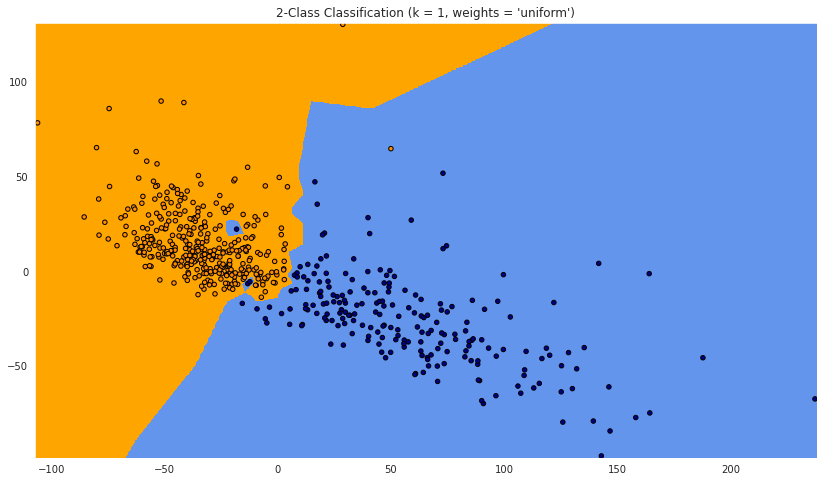

In [26]:
cmap_light = ListedColormap(['orange', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', "darkblue"])
h = 0.35
X = X_reduced_nca
x_min, x_max = X[:,0].min() -1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() -1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min,y_max,h))

Z = grid_nca.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize = (14,8))
plt.pcolormesh(xx,yy,Z, cmap = cmap_light)

plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,
           edgecolor = 'k', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class Classification (k = %i, weights = '%s')"
         % (len(np.unique(y)), grid_nca.best_estimator_.n_neighbors, grid_nca.best_estimator_.weights));

<a id = "15"></a>
## Finding Wrong Decision

In [27]:
knn = KNeighborsClassifier(**grid_nca.best_params_)
knn.fit(X_train_nca,Y_train_nca)
y_pred_nca = knn.predict(X_test_nca)
acc_test_nca = accuracy_score(y_pred_nca, Y_test_nca)
print("KNN Accuracy: %{}".format(round(knn.score(X_test_nca, Y_test_nca)*100,2)))

KNN Accuracy: %99.42


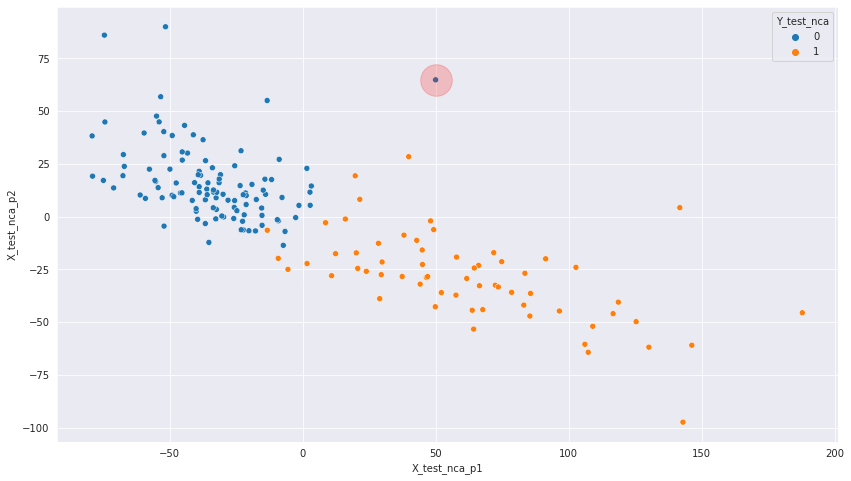

In [28]:
test_data = pd.DataFrame()
test_data["X_test_nca_p1"] = X_test_nca[:,0]
test_data["X_test_nca_p2"] = X_test_nca[:,1]
test_data["y_pred_nca"] = y_pred_nca
test_data["Y_test_nca"] = Y_test_nca

plt.figure(figsize = (14,8))
sns.scatterplot("X_test_nca_p1", y= "X_test_nca_p2", hue ="Y_test_nca", data = test_data)
diff = np.where(y_pred_nca!= Y_test_nca)[0]
plt.scatter(test_data.iloc[diff,0], test_data.iloc[diff,1],label = "Wrong Classified", alpha = 0.2,color = "red", s = 1000)
plt.show()